<font size="6">Lesson 10: Convolutional Neural Networks</font>

Readings:
- [Deep learning, section 9](http://www.deeplearningbook.org/contents/convnets.html)
- [A Comprehensive Guide to Convolutional Neural Networks](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)
- [視覚野と畳み込みニューラルネットワーク](https://lp-tech.net/articles/frQNo)
- [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [73]:
# import what you need
import warnings
warnings.filterwarnings("ignore")
from PIL import Image 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt

--- 

<font size="5">Overviews</font>
1. Introduction
1. Motivations
    1. Sparse interactions
    1. Parameter sharing
    1. Equivariant representations
1. Implementation in PyTorch
1. Summary

In [ ]:
FCC
parameter, time, Grad-CAM, feature, AM, dif among small dif, rota

--- 

# Introduction
In this notebook, I'm going to explain the motivations of (Convolutional Neural Networks)CNN 
and the implementation of it.
This notebook goes subject to the understanding of basic, computation procedure, pooling layer, and batch normalization.
I will introduce 3 main motivations and confirm it with a simple example.
And in the implementation section, I will show how to implement the CNN and compare it with FCC.


---

# Motivations
**Sparse interactions**, **parameter sharing** and **equivariant representations** are 
characteristics of the CNN which is important for the machine learning model to learn efficiently.

## Sparse interactions

## Parameter sharing

## Equivariant representations

# Implementation

In [36]:
def min_max(x, axis=None):
    min = x.min(axis=axis, keepdims=True)
    max = x.max(axis=axis, keepdims=True)
    result = (x-min)/(max-min+1e-8)
    return result

In [37]:
def image_from_output(output):
    image_list = []
    output = output.detach().to("cpu").numpy()
    for i in range(output.shape[0]):
        a = output[i]
        a = np.tile(np.transpose(a, axes=(1,2,0)), (1,1,int(3/a.shape[0])))
        a = min_max(a)*2**8 
        a[a>255] = 255
        a = np.uint8(a)
        a = Image.fromarray(a)
        image_list.append(a)
    return image_list

## Dataset

In [1]:
batch_size = 128
classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

In [3]:
transform = {}
transform["tanh"] = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))])
transform["sigmoid"] = transforms.Compose(
    [transforms.ToTensor() ])

In [7]:
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform)
trainset = torchvision.datasets.MNIST(root='./data',  train=True, download=True, transform=transform["sigmoid"])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [8]:
testset = torchvision.datasets.MNIST(root='./data',  train=False,  download=True,  transform=transform)
testset = torchvision.datasets.MNIST(root='./data',  train=False,  download=True,  transform=transform["sigmoid"])
testloader = torch.utils.data.DataLoader(testset,  batch_size=len(testset), shuffle=False,  num_workers=2)

In [38]:
print(f"len_trainset : {len(trainset)}")
print(f"len_testset : {len(testset)}")

len_trainset : 60000
len_testset : 10000


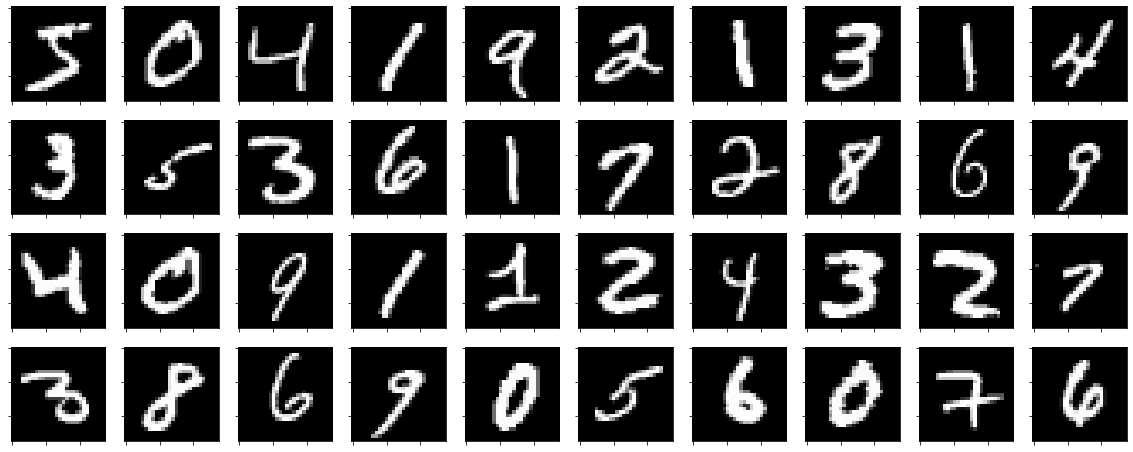

In [44]:
fig = plt.figure(figsize=(20, 8))
for i in range(40):
    image = image_from_output(trainset[i][0].view(1, 1, 28, 28))[0]
    ax = fig.add_subplot(4, 10, i+1)
    ax.imshow(image)
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)

## Model

In [48]:
import torch.optim as optim

In [177]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3, 1, 1)
        self.fc1 = nn.Linear(8 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x)
        return x

In [178]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(1 * 28 * 28, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 32)
        self.fc4 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 1 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = F.softmax(x)
        return x

In [179]:
cnn = CNN()
fcn = FCN()

In [182]:
param_num = 0
for param in list(cnn.state_dict().keys()):
    num = cnn.state_dict()[param].flatten().shape[0]
    print(param, num)
    param_num += num
print("whole", param_num)

conv1.weight 36
conv1.bias 4
conv2.weight 288
conv2.bias 8
fc1.weight 47040
fc1.bias 120
fc2.weight 1200
fc2.bias 10
whole 48706


In [183]:
param_num = 0
for param in list(fcn.state_dict().keys()):
    num = fcn.state_dict()[param].flatten().shape[0]
    print(param, num)
    param_num += num
print("whole", param_num)

fc1.weight 94080
fc1.bias 120
fc2.weight 10080
fc2.bias 84
fc3.weight 2688
fc3.bias 32
fc4.weight 320
fc4.bias 10
whole 107414


In [118]:
img = trainset[0][0].view(1, 1, 28, 28)